In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from numba import jit
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import root_scalar, curve_fit
from pynndescent import NNDescent
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA

In [2]:
def exp_k(dists, sigma):
    return np.exp(- (dists - dists[0]) / sigma).sum()

In [3]:
def find_sigma(d, k, lower_bound=1e-6, upper_bound=1e6):
    return root_scalar(
        lambda s: exp_k(d, s) - np.log2(k),
        bracket=(lower_bound, upper_bound)
    ).root

In [48]:
def p_ij_sym(x, k, verbose=False):
    num_pts = x.shape[0]
    if verbose:
        print('Indexing')
    index = NNDescent(x,
        n_neighbors=k)
    neighbors = np.empty((num_pts, k), dtype=np.int)
    p_ij = np.empty((num_pts, k))
    for i, xi in enumerate(x):
        if verbose:
            print('Calculating probabilities: {cur}/{tot}'.format(
                cur=i+1, tot=num_pts), end='\r')
        nn, dists = index.query([xi], k+1)
        sigma = find_sigma(dists[0, 1:], k)
        neighbors[i] = nn[0, 1:]
        p_ij[i] = np.exp(- (dists[0, 1:] - dists[0, 1]) / sigma)
    row_indices = np.repeat(np.arange(num_pts), k)
    p = csr_matrix((p_ij.ravel(), (row_indices, neighbors.ravel())))
    return p + p.transpose() - (p.multiply(p.transpose()))

In [5]:
def pdiff(x):
    batch_size = x.shape[0]
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)  
    return diffs

In [6]:
def find_ab_params(spread, min_dist):
    """Fit a, b params for the differentiable curve used in lower
    dimensional fuzzy simplicial complex construction. We want the
    smooth curve (from a pre-defined family with simple gradient) that
    best matches an offset exponential decay.
    """

    def curve(x, a, b):
        return 1.0 / (1.0 + a * x ** (2 * b))

    xv = np.linspace(0, spread * 3, 300)
    yv = np.zeros(xv.shape)
    yv[xv < min_dist] = 1.0
    yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
    params, covar = curve_fit(curve, xv, yv)
    return params[0], params[1]

In [7]:
def dist_mat_squared(x):
    batch_size = x.shape[0]
    expanded = x.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)    
    return sum_act

In [8]:
# more memory-efficient version of distmat
def dist_mat_squared_new(x):
    n = x.shape[0]
    distmat_cond = F.pdist(x)
    distmat = torch.zeros((n,n), device=x.device)
    a,b = torch.triu_indices(n, n, offset=1)
    distmat[[a,b]] = distmat_cond.pow(2)
    return distmat + distmat.T

In [9]:
def q_ij(x, a, b):
    dists = dist_mat_squared_new(x)
    dists.fill_diagonal_(1.)
    q = torch.pow(1 + a * torch.pow(dists, b), -1)
    q.fill_diagonal_(0.)
    return q

In [10]:
def submatrix(m, indices):
    dim = len(indices)
    indices = np.array(np.meshgrid(indices, indices)).T.reshape(-1,2).T
    return torch.tensor(m[indices[0], indices[1]].reshape(dim, dim))

In [11]:
def umap_loss(p, q, eps=1.0e-7):
    eps = torch.tensor(eps, dtype=p.dtype)
    l_a = torch.mul(p, torch.log(p + eps) - torch.log(q + eps))
    l_b = torch.mul(1 - p, torch.log(1 - p + eps) - torch.log(1 - q + eps))
    loss_mat = l_a + l_b
    loss_mat.fill_diagonal_(0.)
    return torch.sum(loss_mat)

In [49]:
class Parametric_UMAP(nn.Module):
    
    def __init__(self, input_dim, output_dim, knn, min_dist,
                 spread=1.0,
                 hidden_layer_dims=None,
                 seed=None,
                 use_cuda=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.knn = knn
        self.min_dist = min_dist
        self.spread = spread
        
        self.a, self.b = find_ab_params(self.spread, self.min_dist)
        
        self.use_cuda = use_cuda
        
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            # x = torch.sigmoid(layer(x))
            x = F.softplus(layer(x))
        out = self.layers[-1](x)
        return out
    
    def pretrain(self, training_data,
            epochs=10,
            verbose=False,
            batch_size=500,
            learning_rate=0.01):
        if verbose:
            print('Calculating PCA')
        pca = torch.tensor(PCA(n_components=2).fit_transform(training_data), dtype=training_data.dtype)
        
        dataset = torch.utils.data.TensorDataset(training_data, pca)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        if verbose:
            print('{time}: Beginning pretraining for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, targets = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    targets = targets.cuda()
                    
                optim.zero_grad()
                
                loss = criterion(self(features), targets)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(
                time=datetime.datetime.now()))
        
    def fit(self, training_data,
            p_ij=None,
            pretrain=False,
            epochs=10,
            verbose=False,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
        self._epochs = epochs
        
        if pretrain:
            self.pretrain(training_data, epochs=5, verbose=verbose, batch_size=batch_size)
            
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=verbose)
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.a, self.b)
                loss = umap_loss(p, q)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch+1,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))
            
    def test(self, training_data,
            p_ij=None,
            optimizer=torch.optim.Adam,
            batch_size=500,
            learning_rate=0.01):
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self.p_ij = p_ij
            
        if self.p_ij is None:
            self.p_ij = p_ij_sym(training_data.numpy(), self.knn, verbose=True)
            
        dataset = torch.utils.data.TensorDataset(training_data, torch.arange(training_data.shape[0]))
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        for epoch in range(5):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, indices = data
                
                p = submatrix(self.p_ij, indices.numpy())
                    
                if self.use_cuda:
                    features = features.cuda()
                    p = p.cuda()
                    
                optim.zero_grad()
                
                q = q_ij(self(features), self.a, self.b)
                loss = umap_loss(p, q)
                
                return self(features), p, q, loss
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()

In [135]:
(submatrix(p_precalc, np.random.permutation(np.arange(5000))[:1000]) != 0).sum()

tensor(86006)

-----------------------

In [13]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [14]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [34]:
import pandas as pd

In [44]:
iris = pd.read_csv("https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/\
0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv")

In [53]:
# iris_std = (lambda ds: (ds - ds.mean(axis=0)) / ds.std(axis=0))(np.asarray(iris.to_numpy()[:,:4], dtype=np.float32))

In [15]:
testdata = mnist.data.reshape(-1, 28*28) / 255.

In [104]:
foo = Parametric_UMAP(28*28, 2, 300, 0.1, use_cuda=True, hidden_layer_dims=[300,100])

In [98]:
p_precalc = foo.p_ij

In [94]:
bazoo = mnist.targets[:5000].argsort()

In [101]:
np.unique(mnist.targets[:5000], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([479, 563, 488, 493, 535, 434, 501, 550, 462, 495], dtype=int64))

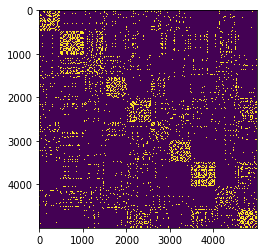

In [100]:
plt.imshow(p_precalc[bazoo][:,bazoo].todense()!=0.)

In [109]:
# foo.fit(testdata[:5000], batch_size=1000, epochs=20, learning_rate=0.001, pretrain=True, verbose=True)
foo.fit(testdata[:5000], p_ij=p_precalc, batch_size=1000, epochs=200, learning_rate=0.001, pretrain=True, verbose=True)

Calculating PCA
2021-07-29 11:32:26.458808: Beginning pretraining for 5 epochs
2021-07-29 11:32:26.618301: Loss after epoch 0: 38.08920502662659
2021-07-29 11:32:26.712240: Loss after epoch 1: 15.885786771774292
2021-07-29 11:32:26.764826: Loss after epoch 2: 11.273713946342468
2021-07-29 11:32:26.837784: Loss after epoch 3: 7.815985798835754
2021-07-29 11:32:26.918121: Loss after epoch 4: 3.9026924073696136
2021-07-29 11:32:26.918121: Finished pretraining
2021-07-29 11:32:26.918121: Beginning training for 200 epochs
2021-07-29 11:32:27.914147: Loss after epoch 1: 748043.456723979
2021-07-29 11:32:28.960112: Loss after epoch 2: 502060.0670751154
2021-07-29 11:32:29.976637: Loss after epoch 3: 350868.0620952796
2021-07-29 11:32:30.949630: Loss after epoch 4: 252869.53860566637
2021-07-29 11:32:32.010199: Loss after epoch 5: 190769.74815408845
2021-07-29 11:32:33.081850: Loss after epoch 6: 148502.05032771762
2021-07-29 11:32:34.134875: Loss after epoch 7: 120520.60004082086
2021-07-29 1

In [110]:
bar = foo(testdata[:5000].cuda()).cpu().detach().numpy()

In [21]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

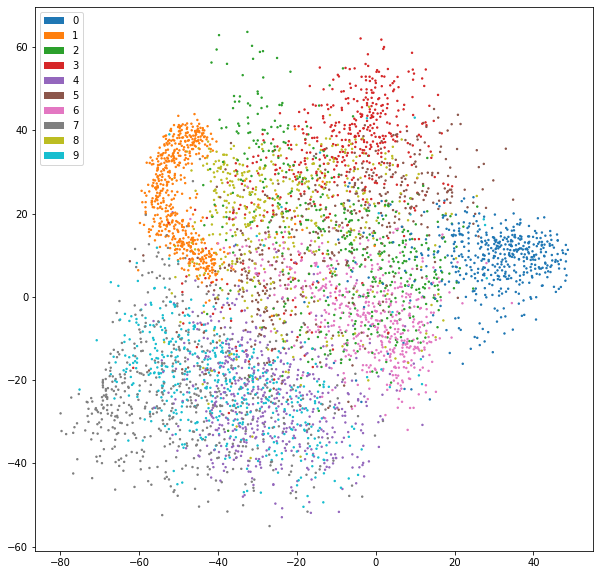

In [111]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:5000]]
#colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(bar[:,0],bar[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [ ]:
foof, foop, fooq, fool = foo.test(testdata[:20000], p_ij=p_precalc, batch_size=500, learning_rate=0.1)

In [ ]:
foop.min()

In [ ]:
a = foop.detach().cpu()

In [ ]:
a

In [ ]:
b = foof.clone().detach().cpu().requires_grad_(True)

In [ ]:
c = q_ij(b, 1.93, 0.79)

In [ ]:
c

In [ ]:
(a/c).fill_diagonal_(0.).min()

In [ ]:
b.grad

In [ ]:
a = torch.tensor([[0.5, 0.6], [0.7, 0.3]])
b = torch.tensor([[0.1, 0.2], [0.4, 0.3]], requires_grad=True)
c = q_ij(b, 1.93, 0.79)

In [ ]:
umap_loss(a, c).backward()

In [ ]:
b.grad

In [85]:
from umap import UMAP

In [93]:
embu = UMAP(n_neighbors=10, min_dist=.1).fit_transform(iris_std)

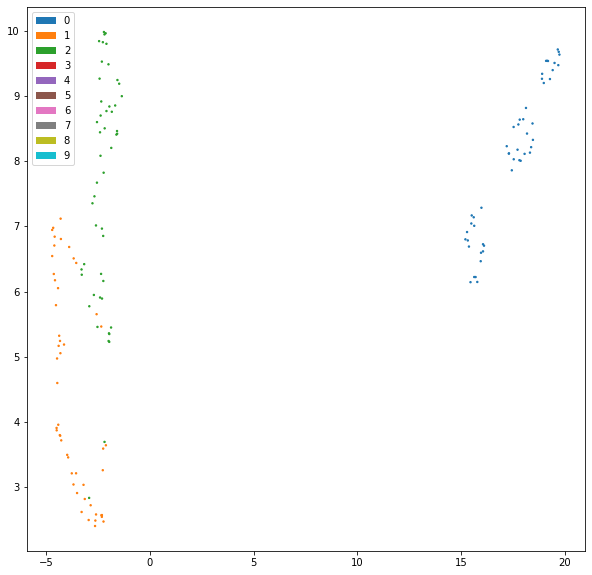

In [94]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
# colors = [plt.cm.tab10.colors[i] for i in mnist.targets[:10000]]
colors = [plt.cm.tab10.colors[i] for i in np.repeat(np.arange(3),50)]
ax.scatter(embu[:,0],embu[:,1],c=colors, s=2)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [122]:
import networkx as nx

In [154]:
baz = np.zeros(p_precalc.shape, dtype=np.int8)

In [155]:
baz[p_precalc.nonzero()] = 1